In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.cluster.vq import kmeans2
import scipy.io
from skimage import color
import colorsys
from scipy.optimize import curve_fit

%matplotlib inline

In [2]:
N_pairs = 75
field_size = 16. # degrees

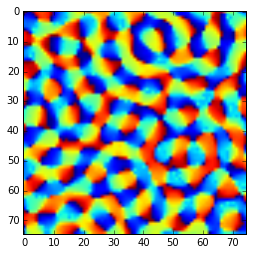

In [3]:
# load orientation preference map

data = scipy.io.loadmat('orientation-map.mat')
k_map = data['map']

plt.figure()
plt.imshow(k_map)

Throwing away the alpha channel...


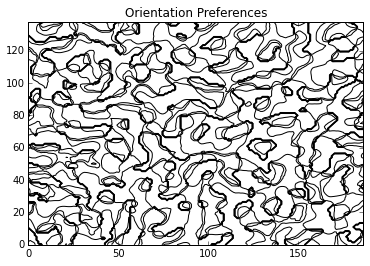

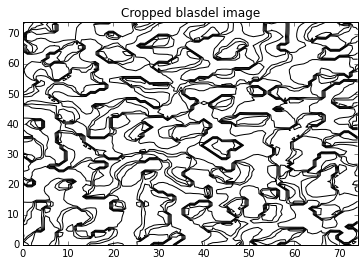

In [4]:
# Orientation map from Oberymayer and Blasdel, 1993:

rgb_img = mpimg.imread('orientation-obermayer-fig1.png')
if rgb_img.shape[2] > 3:
    print "Throwing away the alpha channel..."
    rgb_img = rgb_img[:,:,0:-1]

hsv_img = np.zeros_like(rgb_img)
for i in range(rgb_img.shape[0]):
    for j in range(rgb_img.shape[1]):
        hsv_img[i,j,:] = colorsys.rgb_to_hsv(rgb_img[i,j,0],rgb_img[i,j,1],rgb_img[i,j,2])
    
inds = np.round(np.linspace(0,rgb_img.shape[0], N_pairs, False)).astype(int)
h_chan = hsv_img[:,:,0]
b_map = h_chan[inds[:,np.newaxis],inds+rgb_img.shape[1]-rgb_img.shape[0]]

plt.figure()
# plt.imshow(b_map_full)
# plt.colorbar()
plt.contour(h_chan, 4, colors='k')
plt.title("Orientation Preferences")

plt.figure()
# plt.imshow(b_map)
plt.contour(b_map, 4, colors='k')
plt.title("Cropped blasdel image")



[ 0.40625     0.48046875  0.5234375   0.55078125  0.625       0.73046875]


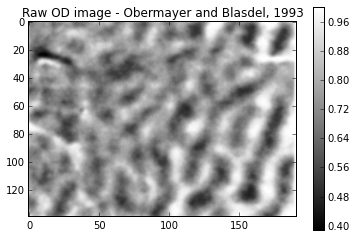

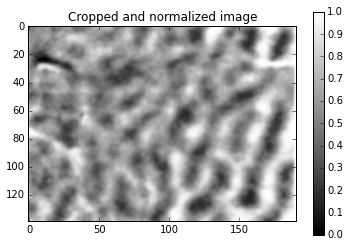

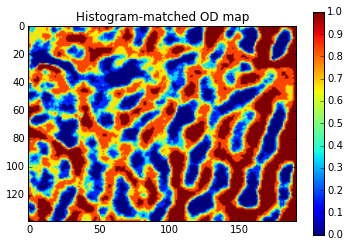

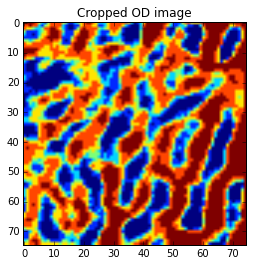

In [5]:
# Ocular dominance map: from Obermayer and Blasdel, 1993
# which contains images of ocular dominance and orientation preference from the same region

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

OD_raw = mpimg.imread('ocular-dom-obermayer-fig1.png')    
OD_gray = rgb2gray(OD_raw)    
plt.figure()
plt.imshow(OD_gray, cmap = plt.get_cmap('gray'))
plt.title("Raw OD image - Obermayer and Blasdel, 1993")
plt.colorbar()

OD_img = OD_gray

OD_norm = (OD_img - np.min(OD_img) ) / np.max(OD_img - np.min(OD_img))

plt.figure()
plt.imshow(OD_norm, cmap = plt.get_cmap('gray'))
plt.title("Cropped and normalized image")
plt.colorbar()

OD_img_hist, OD_img_bins = np.histogram(OD_norm, bins=256)

OD_img_CDF = np.cumsum(np.array(OD_img_hist).astype(float)/np.sum(OD_img_hist))

# Scale ocular dominance map based on complex cell distribution in 
# layer 3, Hubel and Wiesel 1968, fig. 14, wherein cells are divided into
# 7 groups, 1 meaning total preference for the ipsilateral eye, and 7 for
# total contralateral dominance
OD_target_dist = np.array([26., 22., 17., 9., 30., 37., 35.])
OD_target_prop = OD_target_dist/np.sum(OD_target_dist)
OD_target_CDF = np.cumsum(OD_target_prop)

ocularity_vals = np.linspace(0,1, len(OD_target_dist), endpoint=True)

boundaries = np.zeros(len(OD_target_dist)-1)
j = 0
for i in range(len(OD_img_CDF)):
    if OD_img_CDF[i] >= OD_target_CDF[j] and j < len(OD_target_dist)-1:
        boundaries[j] = i/256.
        j = j+1

print boundaries
        
OD_map = np.zeros_like(OD_norm)

for i in range(len(boundaries)):
    if i == 0:
        OD_map[OD_norm <= boundaries[i]] = ocularity_vals[0]
    elif i == len(boundaries)-1:
        OD_map[OD_norm > boundaries[i]] = ocularity_vals[-1]
        OD_map[np.logical_and(OD_norm < boundaries[i], OD_norm >= boundaries[i-1])] = ocularity_vals[-2]
    else:
        OD_map[np.logical_and(OD_norm <= boundaries[i], OD_norm > boundaries[i-1])] = ocularity_vals[i]
        

# subsample the Blasdel images to get (approximately) the right scale of OD map
inds = np.round(np.linspace(0,OD_map.shape[0], N_pairs, False)).astype(int)
OD_map_cropped = OD_map[inds[:,np.newaxis],inds+OD_map.shape[1]-OD_map.shape[0]]
        
plt.figure()
plt.title("Histogram-matched OD map")
plt.imshow(OD_map)
plt.colorbar()

plt.figure()
plt.title("Cropped OD image")
plt.imshow(OD_map_cropped)

<matplotlib.contour.QuadContourSet instance at 0x107fcb290>

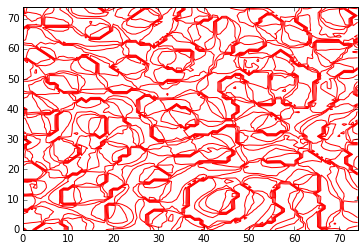

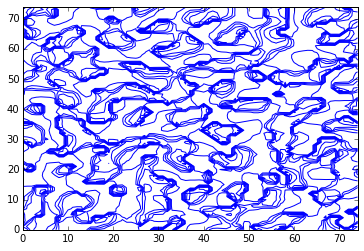

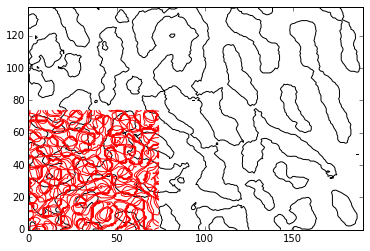

In [6]:
# compare the contour plots of the two orientation maps:
plt.figure()
plt.contour(k_map, 5, colors='r')

plt.figure()
plt.contour(b_map, 6, colors='b')
            
plt.figure()
plt.contour(OD_map, 1, colors='k')
plt.contour(k_map, 5, colors='r')

<matplotlib.contour.QuadContourSet instance at 0x10910cbd8>

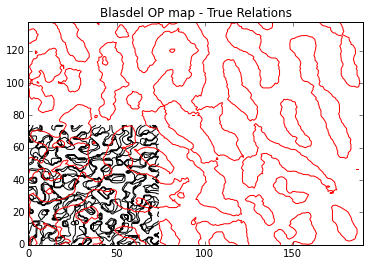

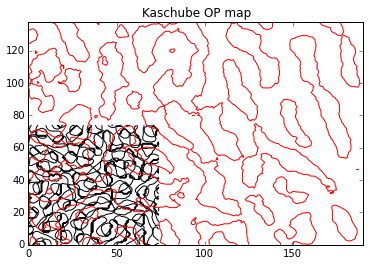

In [7]:
n_contours = 3

plt.figure()
plt.title("Blasdel OP map - True Relations")
plt.contour(b_map, n_contours, colors='k')
plt.contour(OD_map, 1, colors='r')

plt.figure()
plt.title("Kaschube OP map")
plt.contour(k_map, n_contours, colors='k')
plt.contour(OD_map, 1, colors='r')

<matplotlib.contour.QuadContourSet instance at 0x1073a2e60>

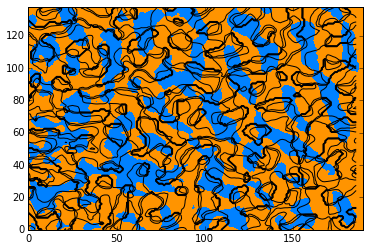

In [12]:
plt.figure()
# plt.contour(OD_map, 1, colors='r', linewidths=2)
plt.contourf(OD_map, 1)
plt.contour(h_chan, 4, colors='k')

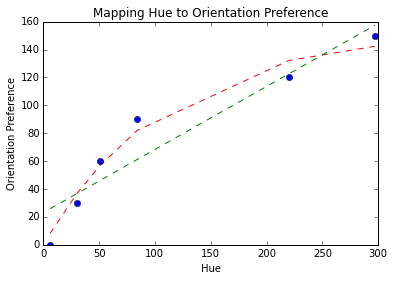

In [22]:
# Use the orientation color key from Obermayer and Blasdel to 
# produce a continuous orientation map from the image:

h_val_key = np.array([6, 30, 51, 84, 220, 297])
ori_key = np.linspace(0,180,len(h_val_key), endpoint=False)

def exp_f(x, a, b):
    return a*(1-np.exp(-x/b) )

def linear_f(x, a, b):
    return a*x + b

popt, pcov = curve_fit(exp_f, h_val_key, ori_key)

plt.figure()
plt.plot(h_val_key, exp_f(h_val_key, popt[0], popt[1]), 'r--')

popt, pcov = curve_fit(linear_f, h_val_key, ori_key)
plt.plot(h_val_key, linear_f(h_val_key, popt[0], popt[1]), 'g--')
plt.plot(h_val_key, ori_key, 'o')
plt.title('Mapping Hue to Orientation Preference')
plt.xlabel('Hue')
plt.ylabel('Orientation Preference')
# plt.legend(["Parabolic Fit", "Linear Fit", "Data"])

146.582 0.0
358.609 0.0
[   0.   30.   60.   90.  120.  150.]


<matplotlib.colorbar.Colorbar instance at 0x10ba2e6c8>

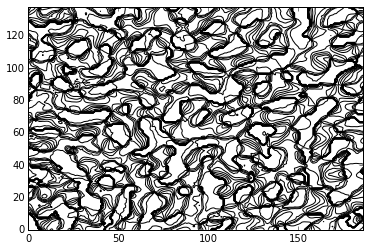

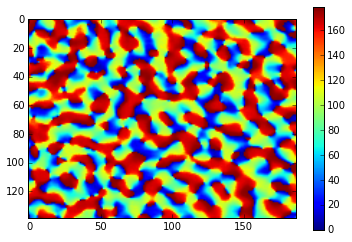

In [17]:
popt, pcov = curve_fit(exp_f, h_val_key, ori_key)

max_h_val = 359
max_o_val = 179

OP_interp = exp_f(h_chan*max_h_val, popt[0], popt[1])
print np.max(OP_interp), np.min(OP_interp)
print np.max(h_chan*max_h_val), np.min(h_chan*max_h_val)
print ori_key
plt.figure()
# plt.imshow(OP_interp)
# plt.colorbar()
plt.contour(OP_interp, 10, colors='k')

OP_norm = OP_interp/np.max(OP_interp)*max_o_val

plt.figure()
plt.imshow(OP_norm)
plt.colorbar()

91.592505035
180.196294038 1.25478125729


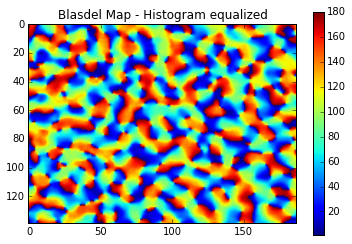

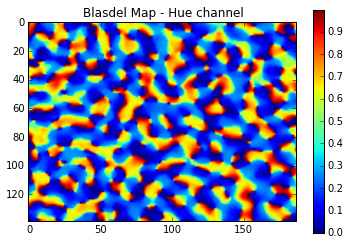

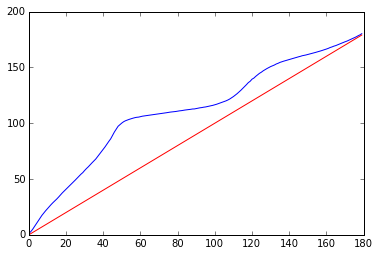

In [49]:
h_chan_hist,bins = np.histogram(h_chan.ravel(), bins=180, normed=True)
h_chan_cdf = h_chan_hist.cumsum()

# use linear interpolation of CDF to find new pixels:
h_eq = np.interp(h_chan.flatten(), bins[:-1], h_chan_cdf)

OP_eq = h_eq.reshape(h_chan.shape)

plt.figure()
plt.imshow(OP_eq)
plt.colorbar()
plt.title('Blasdel Map - Histogram equalized')

plt.figure()
plt.imshow(h_chan)
plt.colorbar()
plt.title('Blasdel Map - Hue channel')
           
plt.figure()
plt.plot(h_chan_cdf)
plt.plot(range(180), 'r')

print np.mean(OP_eq)
print np.max(OP_eq), np.min(OP_eq)

Normalized values:  0.0 0.998911
[ 0.          0.00555556  0.01111111  0.01666667  0.02222222  0.02777778
  0.03333333  0.03888889  0.04444444  0.05        0.05555556  0.06111111
  0.06666667  0.07222222  0.07777778  0.08333333  0.08888889  0.09444444
  0.1         0.10555556  0.11111111  0.11666667  0.12222222  0.12777778
  0.13333333  0.13888889  0.14444444  0.15        0.15555556  0.16111111
  0.16666667  0.17222222  0.17777778  0.18333333  0.18888889  0.19444444
  0.2         0.20555556  0.21111111  0.21666667  0.22222222  0.22777778
  0.23333333  0.23888889  0.24444444  0.25        0.25555556  0.26111111
  0.26666667  0.27222222  0.27777778  0.28333333  0.28888889  0.29444444
  0.3         0.30555556  0.31111111  0.31666667  0.32222222  0.32777778
  0.33333333  0.33888889  0.34444444  0.35        0.35555556  0.36111111
  0.36666667  0.37222222  0.37777778  0.38333333  0.38888889  0.39444444
  0.4         0.40555556  0.41111111  0.41666667  0.42222222  0.42777778
  0.43333333  0.43

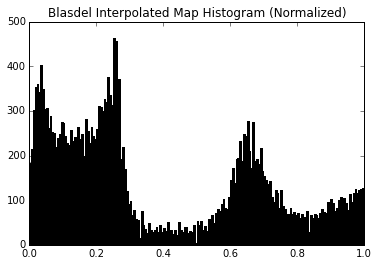

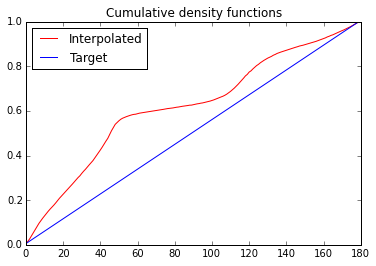

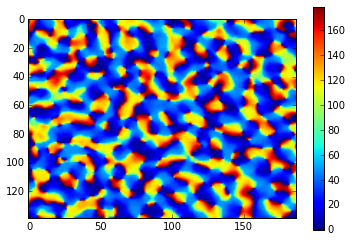

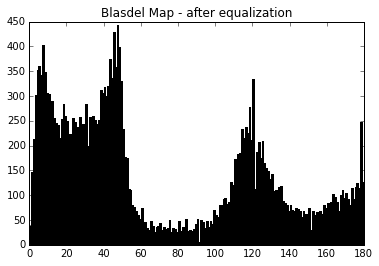

In [41]:
# we want a uniform distribution of orientation preferences, 
# so perform histogram equalization on the interpolated map

# OP_norm = OP_interp/np.max(OP_interp)
OP_norm = h_chan
print "Normalized values: ", np.min(OP_norm), np.max(OP_norm)

plt.figure()
plt.hist(OP_norm.ravel(), bins=180, range=(0.0, 1.0), fc='k', ec='k')
plt.title("Blasdel Interpolated Map Histogram (Normalized)")

OP_img_hist, OP_img_bins = np.histogram(OP_norm, bins=180)
OP_img_CDF = np.cumsum(np.array(OP_img_hist).astype(float)/np.sum(OP_img_hist))

OP_target_dist = OP_interp.size/180*np.ones(180)
OP_target_prop = OP_target_dist/np.sum(OP_target_dist)
OP_target_CDF = np.cumsum(OP_target_prop)

plt.figure()
plt.plot(np.arange(180), OP_img_CDF, 'r', label='Interpolated')
plt.plot(np.arange(180), OP_target_CDF, 'b', label='Target')
plt.title('Cumulative density functions')
plt.legend(loc='best')

ori_vals = np.arange(180)

boundaries = np.zeros(len(OP_target_dist)-1)
j = 0
for i in range(len(OP_img_CDF)):
    if OP_img_CDF[i] >= OP_target_CDF[j] and j < len(OP_target_dist)-1:
        boundaries[j] = i/180.
        j = j+1

# print boundaries
        
OP_map_eq = np.zeros_like(OP_norm)

for i in range(len(boundaries)):
    if i == 0:
        OP_map_eq[OP_norm <= boundaries[i]] = ori_vals[0]
    elif i == len(boundaries)-1:
        OP_map_eq[OP_norm > boundaries[i]] = ori_vals[-1]
        OP_map_eq[np.logical_and(OP_norm < boundaries[i], OP_norm >= boundaries[i-1])] = ori_vals[-2]
    else:
        OP_map_eq[np.logical_and(OP_norm <= boundaries[i], OP_norm > boundaries[i-1])] = ori_vals[i]
        
plt.figure()
plt.imshow(OP_map_eq)
plt.colorbar()

plt.figure()
plt.hist(OP_map_eq.ravel(), bins=180, range=(0.0, 180.0), fc='k', ec='k')
plt.title("Blasdel Map - after equalization")

<matplotlib.contour.QuadContourSet instance at 0x108bef7a0>

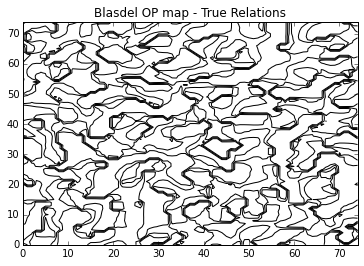

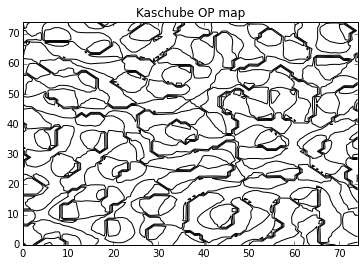

In [15]:
n_contours = 3

plt.figure()
plt.title("Blasdel OP map - True Relations")
interp_map_cropped = OP_norm[inds[:,np.newaxis],inds+rgb_img.shape[1]-rgb_img.shape[0]]
plt.contour(interp_map_cropped, n_contours, colors='k')
# plt.contour(OD_map, 1, colors='r')

plt.figure()
plt.title("Kaschube OP map")
plt.contour(k_map, n_contours, colors='k')
# plt.contour(OD_map, 1, colors='r')

107.92 88.2525584906


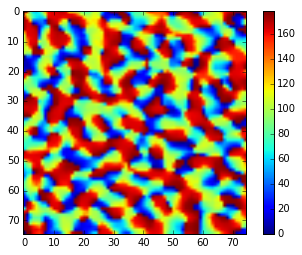

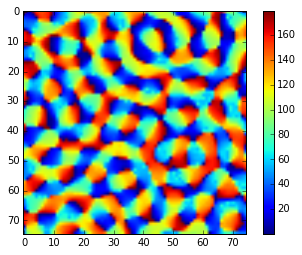

In [16]:
plt.figure()
plt.imshow(interp_map_cropped)
plt.colorbar()

plt.figure()
plt.imshow(k_map)
plt.colorbar()

print np.mean(interp_map_cropped), np.mean(k_map)

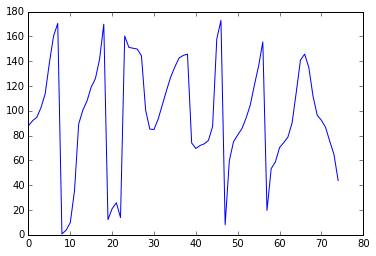

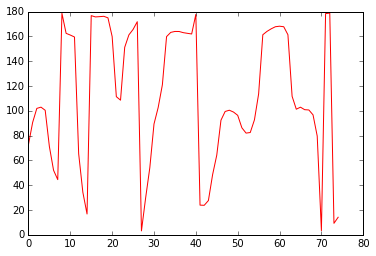

In [19]:
plt.figure()
plt.plot(np.arange(0,75), k_map[37,:], 'b', label='Kaschube Map')

plt.figure()
plt.plot(np.arange(0,75), interp_map_cropped[37,:], 'r', label='Cropped Blasdel Map')

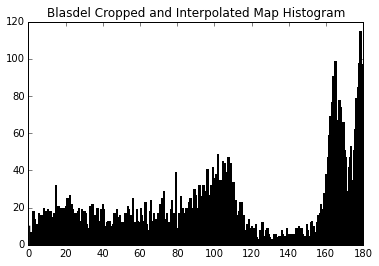

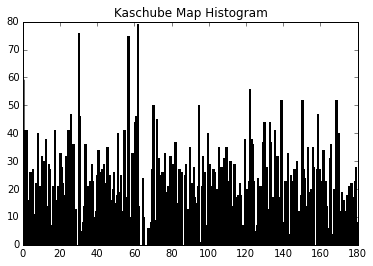

In [21]:
# Histogram analysis of each map:
plt.figure()
plt.hist(interp_map_cropped.ravel(), bins=256, range=(0.0, 180.0), fc='k', ec='k')
plt.title("Blasdel Cropped and Interpolated Map Histogram")

plt.figure()
plt.hist(k_map.ravel(), bins=256, range=(0.0, 180.0), fc='k', ec='k')
plt.title("Kaschube Map Histogram")